In [1]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *

import sklearn
import pandas as pd

from scipy.stats import bernoulli

from operator import xor

import os


In [2]:
def load_enhancer(include_groups = True):
    
    dataset = "enhancer"

    parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_dir, "data", dataset, dataset+"_data.csv")
    
    df = pd.read_csv(data_path)

    # Labels
    labels = df['Regulated'].values
    
    noisy_labels = df['Regulated'].values
    
    power = df['PowerAtEffectSize25'].values

    # Encode 'sex' using LabelEncoder
    label_encoder = LabelEncoder()

    df['chr'] = label_encoder.fit_transform(df['chr'])

    # Groups
    groups =  df["chr"].values


    feature_cols = list(df.columns[-12:])


    if include_groups:
        df_features = df[feature_cols + ["chr"]]

    else:
        df_features = df[feature_cols]
    features = pd.get_dummies(df_features).values.astype(int)


    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit and transform the data
    features = scaler.fit_transform(features)
    
            
    return features, labels.astype(int), power,  groups


In [3]:
dataset = "enhancer_imbalanced"
noise_type = "group"

batch_size = 512


In [4]:
import numpy as np
from collections import defaultdict

def generate_T_dict(power, groups, noise_level):
    # Initialize a dictionary to store transition matrices
    transition_matrices = defaultdict(list)
    
    # Combine power values and group assignments into a structured array
    data = list(zip(power, groups))
    
    # Convert to numpy array for easier handling (optional, but useful for larger data)
    data = np.array(data, dtype=[('power', float), ('group', int)])
    
    # Find unique groups
    unique_groups = np.unique(groups)
    
    # Iterate over each group to compute the transition matrix
    for group in unique_groups:
        # Filter power values for the current group
        group_power_values = np.nan_to_num(data['power'][data['group'] == group], nan=1)
        
    
        # Calculate average power for the group
        avg_power = np.mean(group_power_values)
        
        # Calculate T2 error as (1 - avg_power)
        t2_error = 1 - avg_power
        
        # Ensure t2_error is within [0, 1] range
        if not (0 <= t2_error <= 1):
            raise ValueError(f"Invalid T2 error {t2_error} for group {group}. Ensure power values are valid.")
        
        
        # Define the transition matrix using the formula
        transition_matrix = np.array([
            [1 - noise_level, noise_level],  # Not Sig -> Sig (Type I Error)
            [t2_error, 1 - t2_error]         # Sig -> Not Sig (Type II Error)
        ])
        
        # Store the transition matrix in the dictionary with group as the key
        transition_matrices[group] = transition_matrix
    
    return transition_matrices


In [5]:
def generate_abstain_data_enhancer(n_models, max_iter, model_type = "LR", epsilon = 0.1, noise_level = 0.1):
    
    losses = []
    dis_train = []
    amb_train = []
    new_amb_train = []
    probs_train = []

    dis_test = []
    amb_test = []
    new_amb_test = []
    probs_test = []
    splits = []
    
    features, noisy_labels, power, groups = load_enhancer()
    
    for split in [2024, 2025, 2026, 2027, 2028]:
        X_train, X_test, yn_train, yn_test, group_train, group_test = enhancer_train_test_split(features, noisy_labels, groups, test_size=0.2, random_state=split)

        yn_train = yn_train.astype(int)
        yn_test = yn_test.astype(int)

        p_y_x_dict =  calculate_prior(yn_train, noise_type = noise_type, group=group_train) #Clean prior

        T_dict = generate_T_dict(power, groups, noise_level)

        (disagreement_train, 
        disagreement_test, 
        ambiguity_train, 
        ambiguity_test, 
        new_ambiguity_train, 
        new_ambiguity_test) = run_procedure(n_models, 
                                            max_iter, 
                                            X_train, 
                                            yn_train, 
                                            X_test, 
                                            yn_test, 
                                            p_y_x_dict, 
                                            group_train = group_train, 
                                            group_test = group_test, 
                                            noise_type = noise_type, 
                                            model_type = model_type, 
                                            T = T_dict, 
                                            epsilon = epsilon, 
                                            misspecify = False)

        model, (train_acc,
                        test_acc,
                        train_probs,
                        test_probs,
                        train_loss,
                        test_loss,
                        train_preds,
                        test_preds) = train_model_ours_regret(X_train, yn_train, X_test, yn_test, seed = 2024, model_type=model_type)

        losses.append("BCE")
        dis_train.append(disagreement_train)
        amb_train.append(ambiguity_train)
        new_amb_train.append(new_ambiguity_train)
        probs_train.append(train_probs)

        dis_test.append(disagreement_test)
        amb_test.append(ambiguity_test)
        new_amb_test.append(new_ambiguity_test)
        probs_test.append(test_probs)
        splits.append(split)


    data = {'loss': losses, "disagreement_test":dis_test, "new_ambiguity_train":new_amb_train, "new_ambiguity_test":new_amb_test, "ambiguity_train":amb_train,  "ambiguity_test":amb_test, "disagreement_train":dis_train ,"test_probs":probs_test, "train_probs":probs_train, "split":splits}
    
    return data

In [6]:
from sklearn.metrics import precision_recall_curve, auc

def abstain_order(uncertainty_measures, abstain_count):
    # Sort the indices of the uncertainty measures in descending order
    sorted_indices = np.argsort(uncertainty_measures)[::-1]
    
    # Create a mask vector initialized to 0
    mask = np.zeros_like(uncertainty_measures, dtype=int)
    
    # Set the first 'abstain_count' elements to 1
    mask[sorted_indices[:abstain_count]] = 1
    
    return mask


def compute_abstain_group_stats(abstain_percentage, group_val, group_vec, preds, criteria, y_vec):
    """
    Computes metrics including precision, recall, AUPRC, coverage, and regret for a given group value.

    Parameters:
    - group_val: The group value to compute statistics for.
    - group_vec: Group label vector.
    - preds: Predictions vector.
    - criteria: Criteria used for abstaining.
    - y_vec: Ground truth labels.
    - yn_vec: Noisy labels for anticipated errors (if available).

    Returns:
    - Dictionary containing precision, recall, AUPRC, coverage, regret, and clean risk for the specified group.
    """
    n = len(preds)
    
    abstain_count = int(abstain_percentage * n)
    abstain = abstain_order(criteria, abstain_count)
    
    non_abstain = (1 - abstain).astype(bool)  # abstention vector
    coverage = np.sum(non_abstain) / n
    
    # Filter the data for non-abstained instances
    preds_subset = preds[non_abstain]
    y_vec_subset = y_vec[non_abstain]
    subset_group_vec = group_vec[non_abstain]
    
    err_true = abs(preds - y_vec)
    group_indices = np.where(subset_group_vec == group_val)[0]
    
    if len(group_indices) > 0:
        preds_group = preds_subset[group_indices]
        y_vec_group = y_vec_subset[group_indices]
        
        # Compute precision, recall, and AUPRC
        precision, recall, _ = precision_recall_curve(y_vec_group, preds_group)
        auprc = auc(recall, precision)
        
        noisy_risk = np.mean(err_true[group_indices])
        
        return {
            'precision': 100 * np.mean(precision),
            'recall': 100 * np.mean(recall),
            'noisy_auprc': 100 * auprc,
            'coverage': 100 * coverage,
            'noisy_risk': 100 * noisy_risk
        }
    else:
        return {
            'precision': 0.0,
            'recall': 0.0,
            'noisy_auprc': 0.0,
            'coverage': 100 * coverage,
            'noisy_risk': 0.0
        }

def compute_abstain_stats(abstain_percentage, preds, criteria, yn_vec):
    n = len(preds)
    
    abstain_count = int(abstain_percentage * n)
    abstain = abstain_order(criteria, abstain_count)
    
    non_abstain = (1 - abstain).astype(bool)  # abstention vector
    coverage = np.sum(non_abstain) / n
    
    # Filter predictions and ground truth for non-abstained instances
    preds_subset = preds[non_abstain]
    yn_vec_subset = yn_vec[non_abstain]
    
    # Calculate error anticipated on the subset
    err_anticipated = abs(preds_subset - yn_vec_subset)
    
    # Calculate noisy risk
    noisy_risk = np.mean(err_anticipated) if coverage > 0 else 0.0
    
    # Compute precision, recall, and AUPRC
    precision, recall, _ = precision_recall_curve(yn_vec_subset, preds_subset)
    auprc = auc(recall, precision)
    
    return {
        'noisy_auprc': 100 * auprc,
        'coverage': 100 * coverage,
        'noisy_risk': 100 * noisy_risk
    }

    
def calculate_metrics_abstain_enhancer(data, noise_level = 0.1, model_type="LR"):
    metrics = []
    values = []
    coverages = []
    thresholds = []
    losses = []
    methods = []
    splits = []
    
    features, noisy_labels, power, groups = load_enhancer()
    
    for split in [2024, 2025, 2026, 2027, 2028]:
        X_train, X_test, yn_train, yn_test, group_train, group_test = enhancer_train_test_split(features, noisy_labels, groups, test_size=0.2, random_state=split)

        yn_train = yn_train.astype(int)
        yn_test = yn_test.astype(int)
        y_vec = yn_test

        # Load abstain data
        #data = generate_abstain_data_enhancer()
        df = pd.DataFrame(data)
        df = df[df["split"]==split]
        for loss in df.loss.unique():

            sub_df = df[(df["loss"] == loss)]

            metric_lis = ['noisy_auprc', 'noisy_risk']
            
            ambiguity = np.clip(sub_df.ambiguity_test.values[0] / 100, 0, 1)
            new = np.clip(sub_df.new_ambiguity_test.values[0] / 100, 0, 1)
            probs = sub_df.test_probs.values[0]

            if probs.ndim == 2:
                preds = np.argmax(probs, axis=1)
                confidence = np.max(probs, axis=1)
            else:
                preds = (probs > 0.5).astype(int)
                confidence = np.where(probs > 0.5, probs, 1 - probs)

            uncertainty = 1 - confidence

            for method in ["Ambiguity", "Confidence"]: #["Ambiguity", "Confidence", "Random"]:
                if method == "Ambiguity":
                    criteria = new
                elif method == "Confidence":
                    criteria = uncertainty
                else:
                     criteria = np.random.uniform(0, 1, len(probs))
                #criteria = ambiguity if method == "ambiguity" else uncertainty

                for abstain_percentage in np.linspace(0, 0.045, 100):

                    stats = compute_abstain_stats(abstain_percentage, preds, criteria, y_vec)

                    for metric in metric_lis:

                        metrics.append(metric)

                        values.append(stats[metric])

                        coverages.append(stats['coverage'])
                        thresholds.append(abstain_percentage)

                        losses.append(loss)
                        #groups.append(f"{group}_{group_val}")

                        methods.append(method)
                        splits.append(split)



    # Create a DataFrame from the arrays
    data = pd.DataFrame({
        'metric': metrics,
        'value': values,
        'coverage': coverages,
        'threshold': thresholds,
        'loss': losses,
        'splits':splits,
        'method': methods
    })
    return data
       
### Step 2: Modify `plot_metrics`

def plot_metrics(data, loss_type="BCE", group=False):
    # Calculate the delta risk and delta auprc for abstention rate = 0
    data["abstention"] = 100 - data["coverage"]
    
    # Define your custom color palette for each method
    method_colors = {
        "Ambiguity": "#8896FB",  # Purple
        "Confidence": "#ce3d26",
        "Random": "#ce3d26"  # Red
    }
    
    # Define your custom color palette for each loss type
    loss_colors = {
        "BCE": "#8896FB",
        "forward": "#fc8803",
        "backward": "#4ed476"
    }
    
    # Set the font style to sans-serif
    plt.rcParams["font.family"] = "sans-serif"
    
    # Focus only on metrics where abstention rate is 0
    metrics = ["noisy_risk", "noisy_auprc"]  # Adjusted to delta metrics

    # Create box plots for each metric at abstention rate = 0
    fig, axes = plt.subplots(1, len(metrics), figsize=(5 * len(metrics), 5))
    
        # Calculate baseline values where threshold = 0 for each split, method, and metric
    baseline_data = data[data["threshold"] == 0].set_index(["splits", "method", "metric"])

    # Create a new DataFrame to store the deltas
    delta_data = []
    
    # Loop through each row where threshold is not 0
    for index, row in data[data["threshold"] != 0].iterrows():
        baseline_value = baseline_data.loc[(row["splits"], row["method"], row["metric"]), "value"]
        delta_value = row["value"] - baseline_value  # Calculate the delta
        delta_row = row.copy()
        delta_row["delta"] = delta_value  # Add the delta value to the new row
        delta_data.append(delta_row)

    # Convert the delta_data back into a DataFrame
    delta_data_df = pd.DataFrame(delta_data)
    
    y_labels = {"noisy_risk": "Acc. Increase %", "noisy_auprc": "AUPRC Increase %"}
    for metric, ax in zip(metrics, axes):
        method_data = delta_data_df[delta_data_df["metric"] == metric]
        if metric == "noisy_risk":
            method_data["delta"]= (method_data["delta"]*-1)
        
        method_data["threshold"]= (method_data["threshold"]*100)
        sns.lineplot(data=method_data, x="threshold", y="delta", hue = "method", ax=ax, palette=method_colors)
        ax.legend().remove()  
        ax.set_xlabel("Abstention Rate %", fontsize=14)
        ax.set_ylabel(y_labels[metric], fontsize=14)  # Use Δ symbol for delta
        #ax.set_title(f"{metric.replace('delta_', 'Δ ')}", fontsize=16)
        ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        ax.yaxis.get_major_locator().set_params(integer=True)
    # Add a shared legend at the bottom, as close as possible without extra white space
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), fontsize=15, title_fontsize=16, ncol=3)
    
    plt.tight_layout()
    plt.savefig('/h/snagaraj/noise_multiplicity/figures/enhancer.pdf', dpi=300, bbox_inches='tight')

   
    plt.show()

In [13]:
features, noisy_labels, power, groups = load_enhancer()

In [14]:
features.shape

(9372, 13)

In [7]:
n_models = 1000
max_iter = 10000
model_type = "LR"
epsilon = 1
noise_level = 0.05 #T1 Error

In [8]:


# data = generate_abstain_data_enhancer(n_models, max_iter, noise_level = noise_level, epsilon = epsilon)


In [9]:
# with open("enhancer.pkl", 'wb') as file:
#              # Use pickle to write the dictionary to the file
#     pkl.dump(data , file)


In [10]:
with open("enhancer.pkl", 'rb') as file:
             # Use pickle to write the dictionary to the file
    data = pkl.load(file)


In [42]:
all_metrics = calculate_metrics_abstain_enhancer(data, model_type=model_type, noise_level = noise_level)

/tmp/ipykernel_3430/1656914415.py:236: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method_data["delta"]= (method_data["delta"]*-1)
/tmp/ipykernel_3430/1656914415.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method_data["threshold"]= (method_data["threshold"]*100)
/tmp/ipykernel_3430/1656914415.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

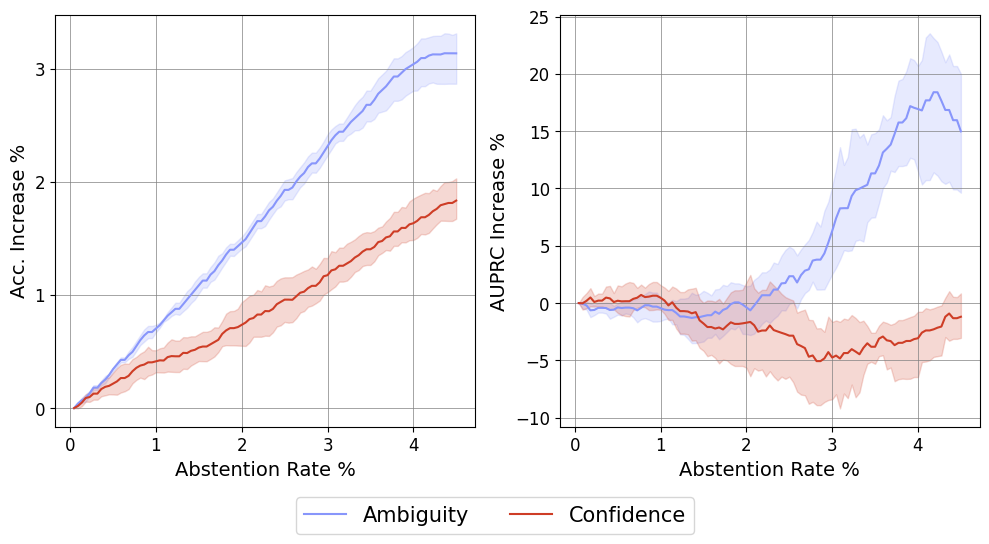

In [43]:
plot_metrics(all_metrics, loss_type="BCE",  group = False)